Importando as bibliotecas necessárias

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
from sklearn.metrics import pairwise_distances
import requests
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import requests
from io import BytesIO


# 1. Classificação dos objetos

Foi utilizado o modelo pré-treinado MobileNetV2, baseado na arquitetura de redes neurais convolucionais, para classificar imagens. A imagem é carregada, redimensionada para 224x224 pixels e pré-processada usando a função preprocess_input. Em seguida, é passada ao modelo, que retorna as classes mais prováveis com suas respectivas probabilidades. As previsões são exibidas junto à imagem original usando a biblioteca Matplotlib. O código também emprega bibliotecas como TensorFlow/Keras (para o modelo), Pillow (manipulação de imagens) e NumPy (manipulação de arrays).

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


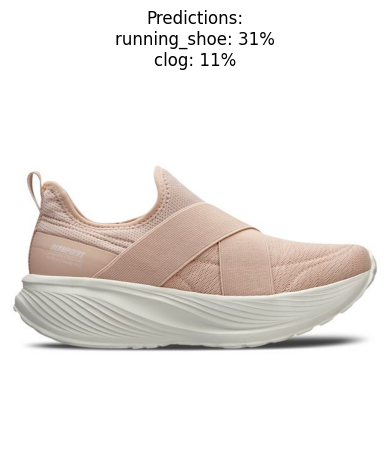

In [100]:
# Carregar o modelo MobileNetV2 pré-treinado
model = MobileNetV2(weights="imagenet")

def load_and_preprocess_image(image_path):
    """Carrega e pré-processa uma imagem para o MobileNetV2."""
    img = Image.open(image_path).resize((224, 224))  # Redimensiona para 224x224
    img_array = np.array(img)
    img_array = preprocess_input(img_array)  # Pré-processamento específico do modelo
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimensão de batch
    return img_array

def classify_image(image_path):
    """Classifica a imagem usando o MobileNetV2."""
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=2)[0]  # Top 3 previsões
    return decoded_predictions

def plot_image_with_predictions(image_path, predictions):
    """Exibe a imagem junto com as previsões do modelo."""
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Predictions:\n" + "\n".join([f"{label}: {prob*100:.0f}%" for (_, label, prob) in predictions]))
    plt.show()

image_path = "/content/250970-600-600.jpeg"
predictions = classify_image(image_path)
plot_image_with_predictions(image_path, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


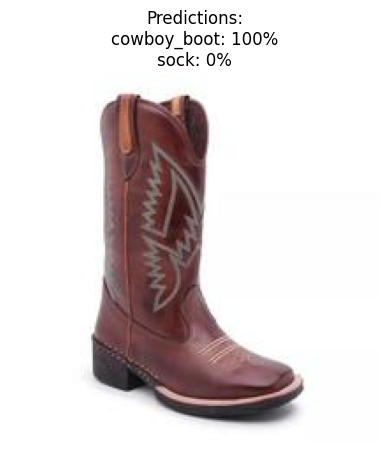

In [101]:
image_path = "/content/7da5fdf4a9b8a223ae13aa1ff94850a1.jpeg"
predictions = classify_image(image_path)
plot_image_with_predictions(image_path, predictions)

# 2. Recomendação dos objetos por similaridade

Para essa parte, o modelo pré-treinado utilizado foi o ResNet50 para extrair características de imagens de produtos de moda, implementando um sistema de recomendação baseado em similaridade. O dataset é baixado com o KaggleHub e as informações dos produtos são carregadas de um arquivo CSV usando Pandas. A primeira parte é a exploração do banco de dados, analisando a distribuição dos produtos por gênero e utilizando Seaborn e Matplotlib para visualizar esses dados. A extração de características é feita com o ResNet50, e as características extraídas das imagens são salvas em arquivos .npy. A recomendação de produtos é feita calculando a distância euclidiana entre as características da imagem de entrada e as imagens do banco de dados. As imagens mais semelhantes são exibidas com suas distâncias de similaridade.

## Baixando o banco de dados e importando as bibliotecas necessárias

In [ ]:
import kagglehub
vikashrajluhaniwal_fashion_images_path = kagglehub.dataset_download('vikashrajluhaniwal/fashion-images')

print('Data source import complete.')


100%|██████████| 335M/335M [00:07<00:00, 44.6MB/s]

Extracting files...


Data source import complete.


## Explorando o banco de dados

In [ ]:
fashion_df = pd.read_csv('/root/.cache/kagglehub/datasets/vikashrajluhaniwal/fashion-images/versions/1/data/fashion.csv')
fashion_df

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


In [ ]:
fashion_df["Gender"].value_counts()

,count
Gender,
Men,811
Women,769
Boys,759
Girls,567


<ipython-input-21-4f0ac9c4f1a6>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels())


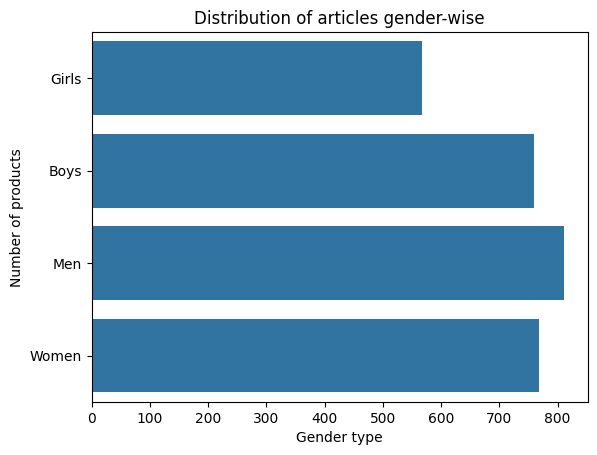

In [ ]:
plot = sns.countplot(fashion_df["Gender"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

## Preparação dos dados e treinamento do modelo

In [104]:
img_width, img_height = 224, 224

train_data_dir = "/root/.cache/kagglehub/datasets/vikashrajluhaniwal/fashion-images/versions/1/data/Footwear/Women/Images"

nb_train_samples = 769
epochs = 100
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict(generator, steps=nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((extracted_features.shape[0], -1))

    np.save(open('./women_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./women_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

extracted_features = np.load('/root/.cache/kagglehub/datasets/vikashrajluhaniwal/fashion-images/versions/1/data/Footwear/women_ResNet_features.npy')
Productids = np.load('/root/.cache/kagglehub/datasets/vikashrajluhaniwal/fashion-images/versions/1/data/Footwear/women_ResNet_feature_product_ids.npy')
women = footwear_women.copy()
df_Productids = list(women['ProductId'])
Productids = list(Productids)

Found 769 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


769/769 ━━━━━━━━━━━━━━━━━━━━ 201s 257ms/step
Time taken in feature extraction 0:03:29.308508


## Previsão com uma imagem de input

In [ ]:
def find_similar_products_in_row(input_image_path, num_results=3):
    # Pré-processar a imagem de entrada
    input_image = process_input_image(input_image_path)

    # Carregar o modelo ResNet50 sem o topo
    model = applications.ResNet50(include_top=False, weights='imagenet')

    # Extrair features da imagem de entrada
    input_features = model.predict(input_image).reshape(1, -1)

    # Calcular distâncias pairwise
    pairwise_dist = pairwise_distances(extracted_features, input_features)
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]

    # Exibir imagens recomendadas
    for i, idx in enumerate(indices):
        rows = women[['ImageURL', 'ProductTitle']].loc[women['ProductId'] == int(Productids[idx])]
        for _, row in rows.iterrows():
            try:
                # Abrir imagem de URL
                response = requests.get(row['ImageURL'])
                recommended_img = Image.open(BytesIO(response.content))

                # Plotar imagem recomendada
                plt.subplot(1, num_results + 1, i + 2)
                plt.imshow(recommended_img)
                plt.axis('off')
                plt.title(f"Recommended {i + 1}\nDist: {pdists[i]:.4f}")
            except Exception as e:
                print(f"Erro ao carregar imagem: {e}")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


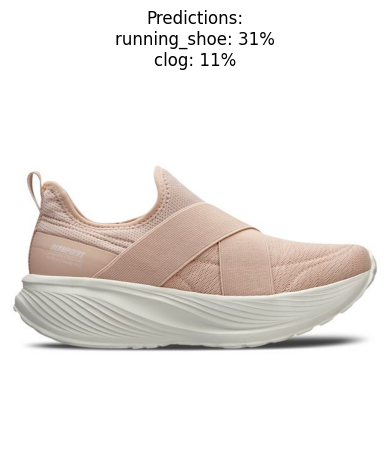

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


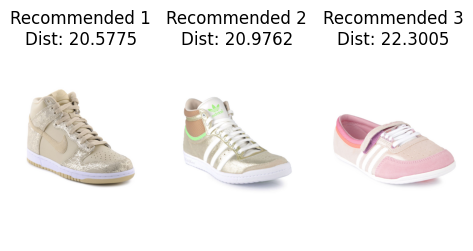

In [109]:
image_path = "/content/250970-600-600.jpeg"
predictions = classify_image(image_path)
plot_image_with_predictions(image_path, predictions)
find_similar_products_in_row(image_path, num_results=3)